In [21]:
import json
import re

import pandas as pd
import pdfplumber

In [2]:
pdf = pdfplumber.open("030819BSTC 3000.pdf")

In [3]:
p0 = pdf.pages[0]

In [4]:
im = p0.to_image(resolution=150).outline_words()

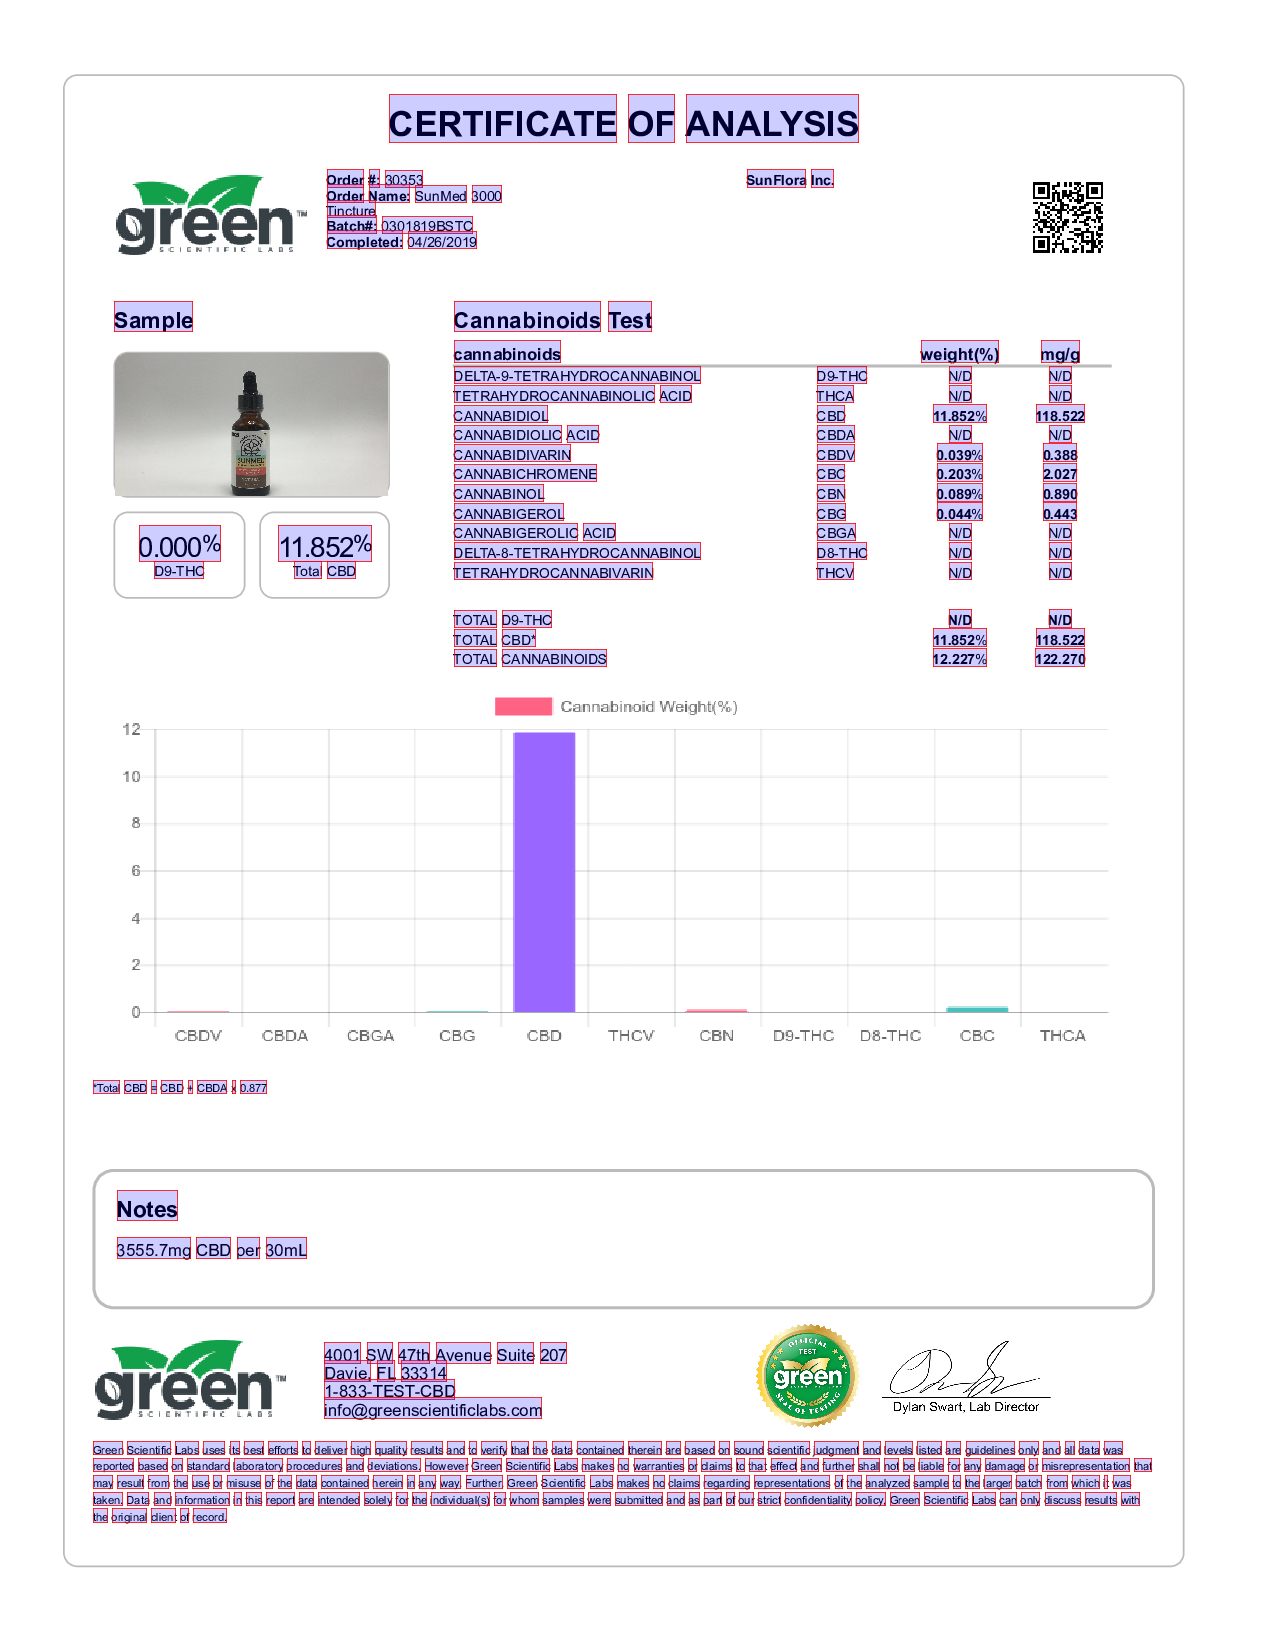

In [5]:
im

In [6]:
rows = p0.extract_words()

In [80]:
text = p0.extract_text().split("\n")

analysis_data = {
    "order_number":   text[1].split(" ", 3)[2],
    "company_name":   text[1].split(" ", 3)[3],
    "order_name":     text[2].split(" ", 2)[2],
    "batch_number":   text[4].split(" ", 1)[1],
    "completed_date": text[5].split(" ", 1)[1]
}

print(json.dumps(analysis_data, sort_keys=True, indent=2))

{
  "batch_number": "0301819BSTC",
  "company_name": "SunFlora Inc.",
  "completed_date": "04/26/2019",
  "order_name": "SunMed 3000",
  "order_number": "30353"
}


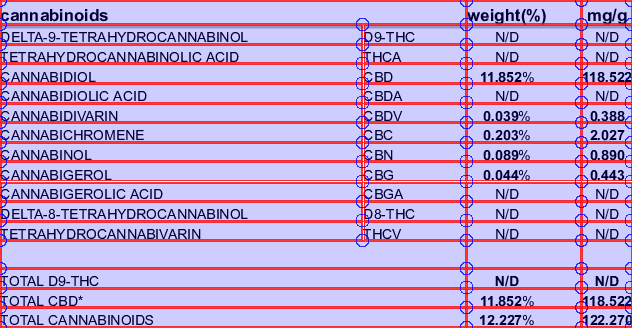

In [23]:
im.reset().debug_tablefinder({
    "vertical_strategy": "text",
    "horizontal_strategy": "text",
    "intersection_x_tolerance": 15
})

In [79]:
# Determine the bounding box for the table area
#  so we can crop it and make extract_table() work
for row in rows:
    #print(row)
    if row["text"] == "cannabinoids":
        x0 = row["x0"]
        top = row["top"]
    if row["text"] == "CANNABINOIDS":
        bottom = row["bottom"]
    if row["text"] == "122.270":
        x1 = row["x1"]

box = (x0, top, x1, bottom) # in prod system these values will be hardcoded
box

(Decimal('217.626'),
 Decimal('163.176'),
 Decimal('521.073'),
 Decimal('320.371'))

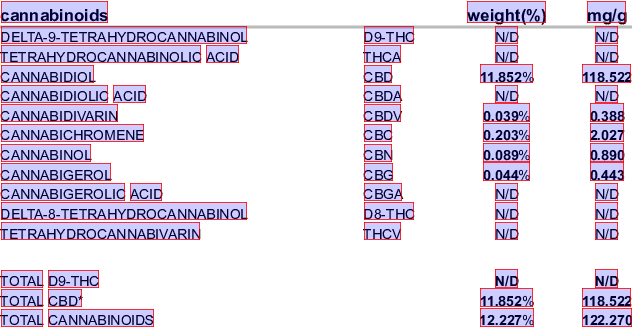

In [28]:
page = p0.crop(bbox=(box))
im2 = page.to_image(resolution=150)
im2.draw_rects(p0.extract_words())

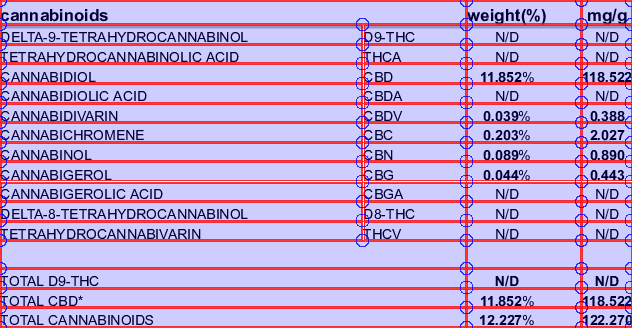

In [14]:
im2.reset().debug_tablefinder({
    "vertical_strategy": "text",
    "horizontal_strategy": "text",
    "intersection_x_tolerance": 15
})

In [81]:
table = page.extract_table({
    "vertical_strategy": "text",
    "horizontal_strategy": "text",
    "intersection_x_tolerance": 15
})

#for row in table:
#    print(row)

df = pd.DataFrame(table)
columns = df.iloc[0]
columns[1] = 'abbrev'
df.columns = columns
totals_df = df.loc[[13,14,15], ["cannabinoids","weight(%)", "mg/g"]] # pull the totals into a new dataframe
df = df.drop([0,12,13,14,15]) # drop the first row and totals
df

,cannabinoids,abbrev,weight(%),mg/g
1,DELTA-9-TETRAHYDROCANNABINOL,D9-THC,N/D,N/D
2,TETRAHYDROCANNABINOLIC ACID,THCA,N/D,N/D
3,CANNABIDIOL,CBD,11.852%,118.522
4,CANNABIDIOLIC ACID,CBDA,N/D,N/D
5,CANNABIDIVARIN,CBDV,0.039%,0.388
6,CANNABICHROMENE,CBC,0.203%,2.027
7,CANNABINOL,CBN,0.089%,0.890
8,CANNABIGEROL,CBG,0.044%,0.443
9,CANNABIGEROLIC ACID,CBGA,N/D,N/D
10,DELTA-8-TETRAHYDROCANNABINOL,D8-THC,N/D,N/D


In [82]:
totals_df

,cannabinoids,weight(%),mg/g
13,TOTAL D9-THC,N/D,N/D
14,TOTAL CBD*,11.852%,118.522
15,TOTAL CANNABINOIDS,12.227%,122.270


In [90]:
# Export the dataframe in Excel (XLSX) format
df.to_excel(r"{}.xlsx".format(analysis_data["batch_number"]), sheet_name="Analysis", index=None, header=True)

In [101]:
# Export the dataframe in CSV format
df.to_csv(r"{}.csv".format(analysis_data["batch_number"]), index=False)

with open(r"{}.csv".format(analysis_data["batch_number"])) as f:
    print(f.read())

cannabinoids,abbrev,weight(%),mg/g
DELTA-9-TETRAHYDROCANNABINOL,D9-THC,N/D,N/D
TETRAHYDROCANNABINOLIC ACID,THCA,N/D,N/D
CANNABIDIOL,CBD,11.852%,118.522
CANNABIDIOLIC ACID,CBDA,N/D,N/D
CANNABIDIVARIN,CBDV,0.039%,0.388
CANNABICHROMENE,CBC,0.203%,2.027
CANNABINOL,CBN,0.089%,0.890
CANNABIGEROL,CBG,0.044%,0.443
CANNABIGEROLIC ACID,CBGA,N/D,N/D
DELTA-8-TETRAHYDROCANNABINOL,D8-THC,N/D,N/D
TETRAHYDROCANNABIVARIN,THCV,N/D,N/D

